# Customer Churn Prediction

This notebook builds and evaluates **customer churn prediction models** using the Telco Customer Churn dataset to predict which customers are at high risk of leaving (churning) so that the business can take proactive steps to retain them (e.g., with special offers or support), which is far more cost-effective than acquiring new customers..

## Objectives
- Understand the data and target variable
- Prepare and preprocess features (handle missing values, types, encoding, scaling)
- Train three models: Logistic Regression, Random Forest, XGBoost
- Evaluate with accuracy, precision, recall, F1, ROC AUC, and confusion matrix
- Compare models and select the best one
- Summarize findings and next steps

## Dataset
The dataset contains customer-level information for a telecom. The target column is `Churn` (Yes/No).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Basic info and target distribution
print(df.shape)
df.info()

print('\nTarget distribution:')
print(df['Churn'].value_counts())
print('\nTarget distribution (normalized):')
print(df['Churn'].value_counts(normalize=True))


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

---
### Analysis of Target Variable Distribution:

The output reveals a significant class imbalance within the target variable, Churn. The majority class, ```No``` (representing customers who did not churn), constitutes approximately **73.5%** of the dataset (5,174 instances), while the minority class, ```Yes```, makes up only about **26.5%** (1,869 instances). This imbalance, with a ratio of nearly 3:1, is a critical characteristic of the dataset that must be addressed. 

A model trained on this data without any adjustments will have a strong inherent bias towards predicting the majority class ("No"). Consequently, while it may achieve a high overall accuracy, its performance in correctly identifying the customers who churn (the "Yes" class) is likely to be poor. Therefore, the modeling strategy must incorporate techniques to handle this imbalance, such as using appropriate evaluation metrics (e.g., F1-score, precision, recall for the "Yes" class) and employing methods like class weighting, oversampling (SMOTE), or choosing algorithms robust to imbalance to build an effective predictive model.

---

In [6]:
# Check missing values 
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

### Exploratory Data Analysis (EDA)

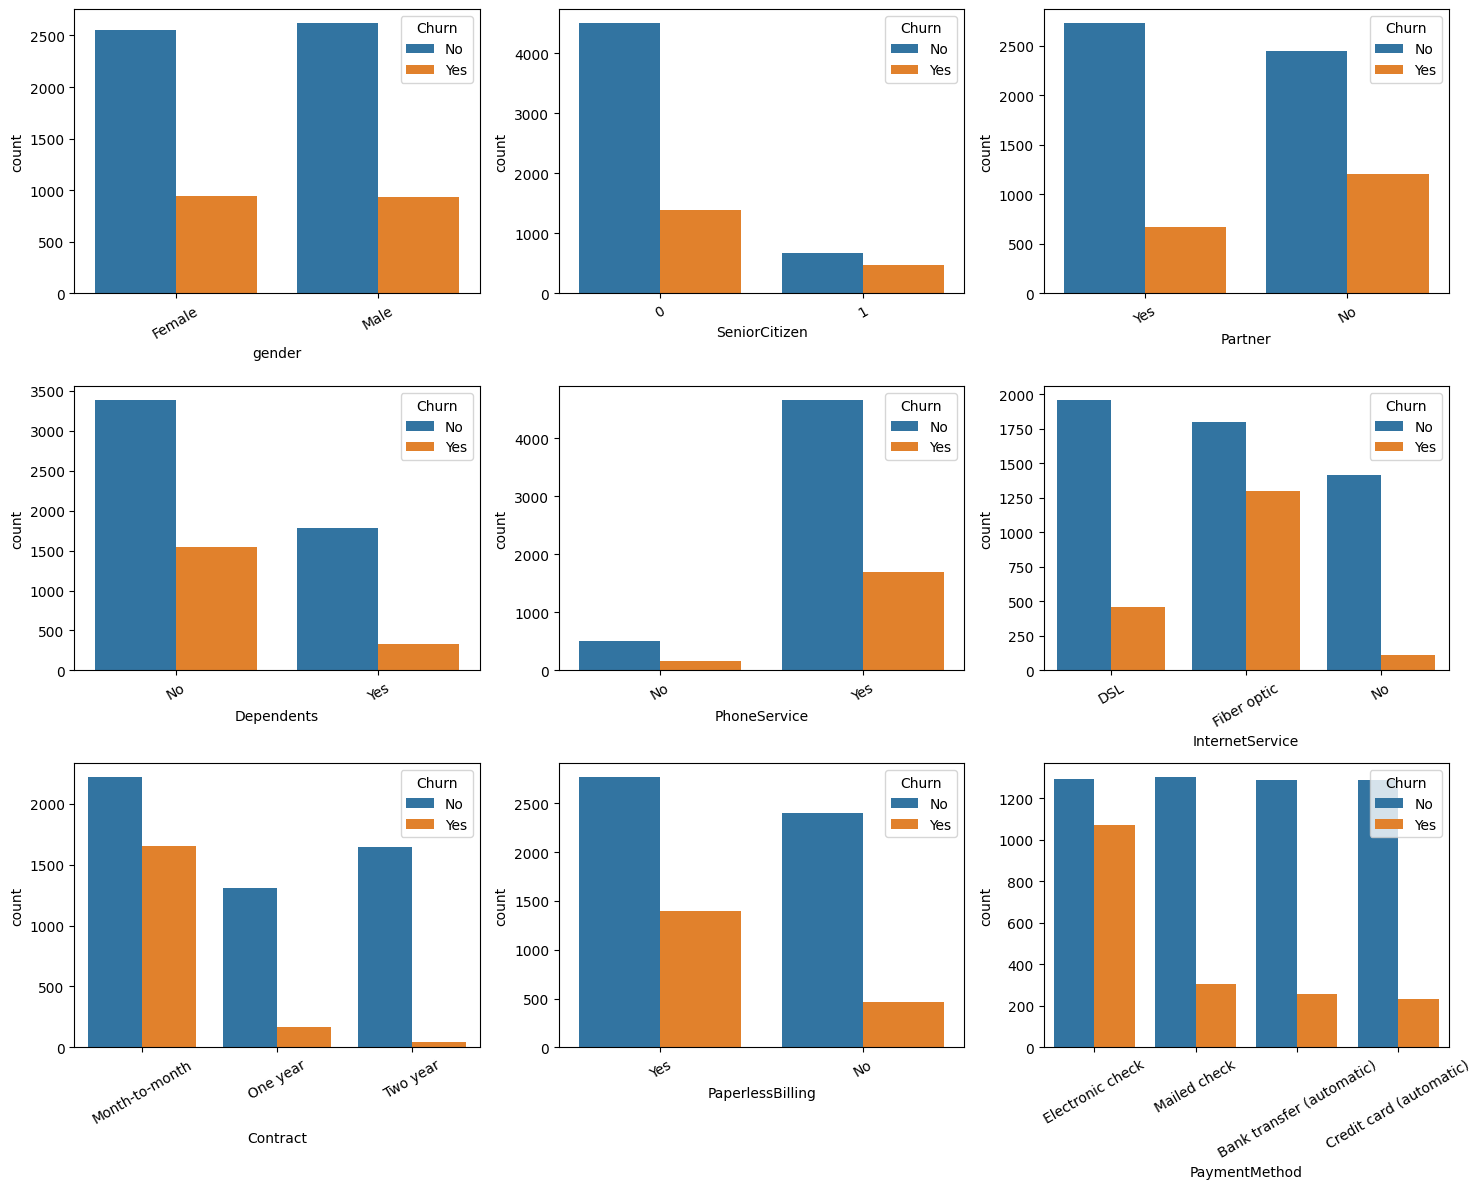

In [7]:
# Quick EDA: visualize target vs few key categorical features
categorical_preview = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','InternetService','Contract','PaperlessBilling','PaymentMethod']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()
for idx, col in enumerate(categorical_preview):
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[idx])
    axes[idx].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


#### Key insights from the plots:
* **Gender:** The churn rate appears almost identical between males and females. Gender does not seem to be a significant differentiating factor in predicting customer churn, as the proportion of "Yes" to "No" is consistent across both groups.
* **Senior Citizen:** This is a highly predictive feature. Non-Senior Citizens have a much lower relative churn rate compared to Senior Citizens. The proportion of churning customers is significantly higher within the Senior Citizen group (value of 1), making this a crucial variable for the model.
* **Partner & Dependents:** These two features tell a similar story. Customers without partners and without dependents exhibit a significantly higher proportion of churn compared to those with partners and dependents. This suggests that customers with greater personal or family ties to the service are less likely to leave.
* **InternetService:** This is one of the most critical features. Customers with Fiber optic service have a dramatically higher churn rate than those with DSL or no internet service. This could indicate issues with service quality, pricing, or competition specifically for fiber optic products.
* **Contract:** This is likely the most important predictor. Customers on a **Month-to-month** contract churn at a vastly higher rate than those with longer-term contracts (One year, Two year). Long-term contracts effectively lock in customer loyalty and are a strong barrier to churn.
* **PaymentMethod:** Payment method is extremely revealing. Customers who use Electronic check have a substantially higher churn rate than those using automated payment methods (credit card, bank transfer). This suggests that the automatic, "set-it-and-forget-it" convenience of automated payments greatly enhances customer retention.

---

### Preprocessing

A couple of crucial steps are taken before building the machine learning model namely:
* **Fix Data Type Issue:** The ```TotalCharges``` column is read as text (object) because it contained blank values (e.g., for new customers who haven't been charged yet). ```pd.to_numeric(..., errors='coerce')``` converts it to a number, turning any problematic values into ```NaN``` (Not a Number).
* **Handle Missing Values:** drop the few rows (11 in the original dataset) where TotalCharges is now ```NaN``` to ensure a clean dataset for the model.
* **Encode the Target Variable:** Convert the Churn column from text ('Yes', 'No') into integers (1, 0).
* **Remove Irrelevant Data:** Drop the customerID column, as a unique identifier is not a predictive feature and would harm model performance.
* **Split the data** into feature variables ```X``` and target Variable ```y``` which is the Churn
* **Create a Preprocessing Pipeline:** This is perhaps the most important step. It defines how to transform the different types of data.
    * For numerical columns it creates a ```Pipeline``` that standardizes them using the ```StandardScaler()```
    * For Categorical Columns it uses ```OneHotEncoder()``` to convert each category into a new binary (0/1) column.
* **Split into Train/Test sets:** splits the data (```X``` and ```y```) into training and testing sets.
    * ```test_size=0.2```: 20% of the data is reserved for testing the final model's performance.

    * ```random_state=42```: Ensures the split is reproducible.

    * ```stratify=y```: Crucially, this ensures that the ratio of ```Churn=1``` to ```Churn=0``` is the same in both the training and test sets as it is in the original dataset. This is essential due to the class imbalance observed.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Coerce TotalCharges to numeric 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges 
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Encode Churn col into binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype(int)

# Remove identifier column
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
#Split the data
X = df.drop(columns=['Churn'])
y = df['Churn']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5625, 19), (1407, 19))

### Model Training
In the next step we train three machine learning models (Logistic Regression, Random Forest, and XGBoost) to predict which customers are at high risk of leaving (churning).

Each model is wrapped in a Pipeline. This is a critical best practice. The pipeline ensures that:

* **Step 1 ('```preprocess```'):** The raw data from ```X_train``` is automatically transformed using the preprocessor (the ```ColumnTransformer``` from the previous code) which handles scaling numeric features and one-hot encoding categorical features.

* **Step 2 (```'model```'):** The transformed data is then passed directly to the model for training. This prevents data leakage and makes the process clean and reproducible.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

log_reg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=200, n_jobs=None))
])

rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced_subsample'))
])

xgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=400, #number of trees
        max_depth=4,
        learning_rate=0.08,
        subsample=0.9, #use 90% of the data
        colsample_bytree=0.8, #use 80% of the features to make the model more robust
        reg_lambda=1.0,
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist'
    ))
])

models = {
    'LogisticRegression': log_reg_clf,
    'RandomForest': rf_clf,
    'XGBoost': xgb_clf
}

for name, model in models.items():
    model.fit(X_train, y_train) #trigger the pipeline and train the model
    print(f"Trained {name}")


Trained LogisticRegression
Trained RandomForest
Trained XGBoost


### Model Evauluation

<Figure size 700x600 with 0 Axes>

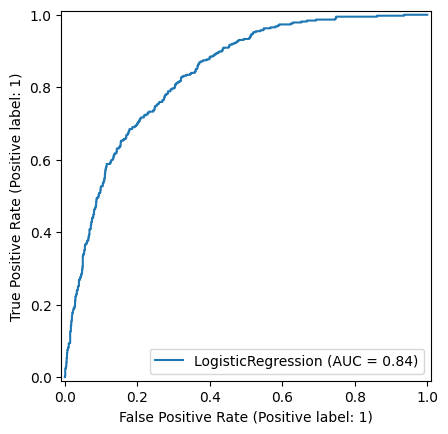

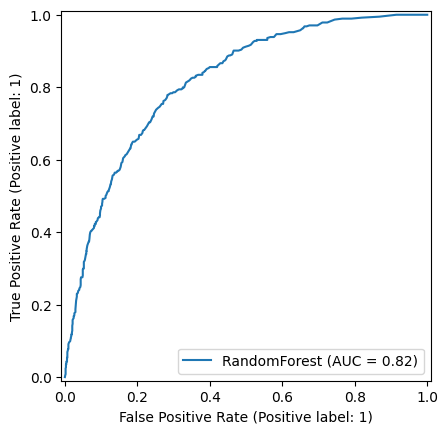

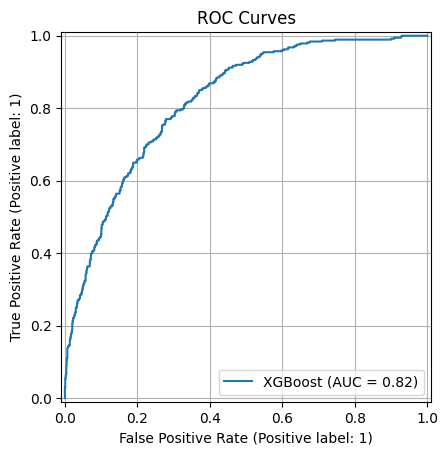

{'LogisticRegression': {'accuracy': 0.8038379530916845,
  'precision': 0.6484848484848484,
  'recall': 0.5721925133689839,
  'f1': 0.6079545454545454,
  'roc_auc': 0.8359290473207676,
  'y_pred': array([0, 1, 0, ..., 0, 0, 0], shape=(1407,)),
  'y_proba': array([0.01751303, 0.59192131, 0.00482103, ..., 0.13098875, 0.02525535,
         0.00444712], shape=(1407,))},
 'RandomForest': {'accuracy': 0.7867803837953091,
  'precision': 0.6284722222222222,
  'recall': 0.4839572192513369,
  'f1': 0.5468277945619335,
  'roc_auc': 0.8155261400520782,
  'y_pred': array([0, 1, 0, ..., 0, 0, 0], shape=(1407,)),
  'y_proba': array([0.00666667, 0.75666667, 0.01333333, ..., 0.02      , 0.01      ,
         0.00333333], shape=(1407,))},
 'XGBoost': {'accuracy': 0.7796730632551528,
  'precision': 0.5963855421686747,
  'recall': 0.5294117647058824,
  'f1': 0.5609065155807366,
  'roc_auc': 0.8212115172567311,
  'y_pred': array([0, 1, 0, ..., 0, 0, 0], shape=(1407,)),
  'y_proba': array([0.00416629, 0.714778

In [22]:
# Evaluation utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

results = {}

plt.figure(figsize=(7,6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # Fallback for models without predict_proba
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)

plt.title('ROC Curves')
plt.grid(True)
plt.show()

results


---
**Logistic Regression** is the best-performing model (highest ```roc_auc value``` **0.835929**) for this specific task and dataset, which is a common and excellent result for a well-preprocessed binary classification problem. It achieved the highest scores across the most important metrics, especially Recall and ROC AUC, meaning it's the best at correctly identifying customers who are likely to churn.

Honestly, I expected **XGBoost** to be the best model for this project, but it was outperformed by the simpler **Logistic Regression** model. In my opinion, this is likely due to a combination of factors. The tree-based model may have been more prone to overfitting, meaning it learned noise from the training data rather than the underlying pattern. Furthermore, the one-hot encoding of categorical variables significantly expanded the feature space, potentially making it more difficult for the complex XGBoost model to generalize effectively compared to the more robust linear model. Finally, without extensive hyperparameter tuning, the default XGBoost configuration might not have been optimal for this specific dataset

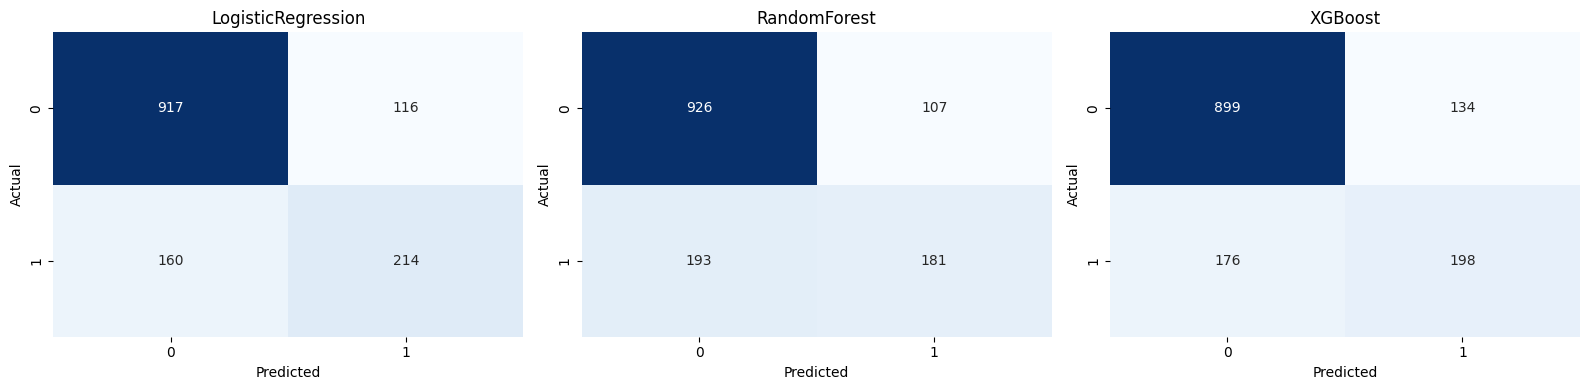

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.803838,0.648485,0.572193,0.607955,0.835929
XGBoost,0.779673,0.596386,0.529412,0.560907,0.821212
RandomForest,0.786780,0.628472,0.483957,0.546828,0.815526


In [23]:
# Confusion matrices and metric table
import itertools

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame({name: {k: v for k, v in res.items() if k in ['accuracy','precision','recall','f1','roc_auc']} for name, res in results.items()}).T
metrics_df.sort_values('roc_auc', ascending=False)


## Conclusion

In conclusion, this project successfully developed a machine learning model to predict customer churn for a telecom company. After evaluating multiple algorithms, **Logistic Regression** was identified as the best-performing model, achieving the highest ROC AUC score of 0.836 and the best balance of precision and recall. This means it is the most effective tool at accurately ranking customers by their risk of churning.

The analysis revealed that the most important factors driving churn are contract type, internet service type, and payment method. Specifically, customers with month-to-month contracts, fiber optic service, and those who pay by electronic check are significantly more likely to leave.
